**Équipe eCSpress :** Seong Woo AHN, Paul BÉRARD, Juliette LÉORAT, Daniel LÉVY, Charlotte SASSON

# Datathon BCG GAMMA x CentraleSupélec

# Étude de cas - LivraisonCo

## Introduction

LivraisonCo est une entreprise française privée de livraison opérant principalement en région parisienne. Son CEO souhaite optimiser son processus de livraison (e.g. livrer plus de colis en un temps réduit, en limitant les coûts) d’une semaine sur l’autre.

Dans le cadre de l'optimisation de ces créneaux, la prédiction de l'état du trafic à Paris d'une semaine sur l'autre constitue un élément clé : cela permettra à notre client d'adapter ses créneaux de livraison pour profiter des temps de fluidité. Il lui manquera cependant des éléments pour optimiser son processus, tels que le nombre de livraisons à réaliser, de créneaux de livraison nécessaires, la répartition de ses livreurs sur ces créneaux, entre autres. Ces éléments seront pris en compte dans la feuille de route proposée dans le livrable 2.

**Objectifs du datathon BCG GAMMA x CentraleSupélec :**
- Appréhender une problématique en réfléchissant aux implications _business_
- Structurer notre travail au sein d'une équipe
- Trier, nettoyer, analyser des grands volumes de données
- Développer et tester des modèles prédictifs
- Élaborer des résultats
- Les présenter à une audience senior

Ce Datathon nous donne l'opportunité de nous confronter à une situation similaire à ce qui se produit dans la vraie vie à BCG GAMMA dans un temps imparti.

## Import des modules nécessaires

In [15]:
import pandas as pd
import numpy as np
import functools
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import calendar
import datetime
from dateutil.parser import parse
from datetime import datetime
from datetime import date
from tqdm import tqdm
import xml.etree.ElementTree as Xet
from pathlib import Path

pd.set_option('display.max_columns', None)

## Chargement des données

### Open Data Paris

Les données du trafic routier parisien sont accessibles depuis le site de la démarche **Open Data de la Ville de Paris** :

- https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents/information/?disjunctive.libelle&disjunctive.etat_trafic&disjunctive.libelle_nd_amont&disjunctive.libelle_nd_aval&sort=t_1h

Le site explique que les données de trafic routier sont issues des **capteurs permanents sur 13 mois glissants en J-1**. Il donne aussi des précisions sur les variables d'intérêt pour notre prédiction :

- Le **taux d’occupation**, qui correspond au temps de présence de véhicules sur la boucle en pourcentage d’un intervalle de temps fixe (une heure pour les données fournies). Ainsi, 25% de taux d’occupation sur une heure signifie que des véhicules ont été présents sur la boucle pendant 15 minutes. Le taux fournit une information sur la congestion routière. L’implantation des boucles est pensée de manière à pouvoir déduire, d’une mesure ponctuelle, l’état du trafic sur un arc.
- Le **débit**, correspondant au nombre de véhicules ayant passé le point de comptage pendant un intervalle de temps fixe (une heure pour les données fournies).

Ainsi, l’**observation couplée** en un point du taux d’occupation et du débit permet de **caractériser le trafic**. Cela constitue l’un des fondements de l’ingénierie du trafic, et l’on nomme d’ailleurs cela le « diagramme fondamental ». Un débit peut correspondre à deux situations de trafic : fluide ou saturée, d’où la nécessité du taux d’occupation. À titre d’exemple : sur une heure, un débit de 100 véhicules par heure sur un axe habituellement très chargé peut se rencontrer de nuit (trafic fluide) ou bien en heure de pointe (trafic saturé).

Afin d'obtenir les données pour les 3 arcs d'intérêt pour le périmètre du PoC (les Champs-Elysées, la rue de la Convention et la rue des Saints-Pères), on utilise le filtre sur le site d'Open Data Paris. Dans le champ **Filtres** à gauche, on renseigne le nom de l’arc et on clique sur le libellé de l’arc, puis on télécharge les enregistrements :

- Pour les Champs-Elysées, on écrit « washington » puis on sélectionne l'arc _AV_Champs_Elysees_.
- Pour la rue de la Convention, on écrit « convention » puis on sélectionne l'arc _Convention_.
- Pour la rue des Saints-Pères, on écrit « Sts » puis on sélectionne l'arc _Sts_Peres_.

In [5]:
champs_elysees = pd.read_csv('data/champs_elysees.csv', sep=';')
convention = pd.read_csv('data/convention.csv', sep=';')
sts_peres = pd.read_csv('data/sts_peres.csv', sep=';')

### Données externes

Pour affiner les informations disponibles et ainsi la précision des prédictions de nos modèles, il est possible d'utiliser des **données externes** apportant des **informations pertinentes**, telles que :

- Données météorologiques [[source](https://www.worldweatheronline.com/weather-api/api/docs/local-city-town-weather-api.aspx)]
- Vacances scolaires et jours fériés [[source](https://www.data.gouv.fr/en/datasets/jours-feries-en-france/)]
- Travaux perturbateurs [[source](https://opendata.paris.fr/explore/dataset/chantiers-perturbants/information/?disjunctive.cp_arrondissement&disjunctive.maitre_ouvrage&disjunctive.objet&disjunctive.impact_circulation&disjunctive.niveau_perturbation&disjunctive.statut)]
- Paris sans voiture [[source](https://www.paris.fr/pages/un-dimanche-par-mois-les-champs-elysees-et-le-centre-de-paris-reserves-aux-pietons-7110)]
- Prix du carburant [[source](https://www.prix-carburants.gouv.fr/rubrique/opendata/)]

Ci-après, on charge les données externes sur Pandas sous forme de DataFrames. On réalisera la jointure de ces données dans la partie suivante (**Ajout des données externes : _feature engineering_**).

#### Vacances scolaires et jours fériés

In [30]:
def get_date(row):
    return row.date()

vacation = pd.read_csv("data/sources_externes/fr-en-calendrier-scolaire.csv", sep=";")
vacation["start_date"] = pd.to_datetime(vacation["start_date"], format='%Y-%m-%d').apply(get_date)
vacation["end_date"] = pd.to_datetime(vacation["end_date"], format='%Y-%m-%d').apply(get_date)
vacation = vacation[(vacation["zones"]=="Zone C") & (vacation["annee_scolaire"].isin(["2021-2022", "2022-2023"])) & (vacation["location"]=="Paris")]
vacation = vacation.reset_index()

vacation.head()

,index,description,population,start_date,end_date,location,zones,annee_scolaire
0,175,Vacances de la Toussaint,-,2021-10-23,2021-11-08,Paris,Zone C,2021-2022
1,183,Vacances d'Hiver,-,2022-02-19,2022-03-07,Paris,Zone C,2021-2022
2,244,Pont de l'Ascension,-,2023-05-18,2023-05-22,Paris,Zone C,2022-2023
3,449,Vacances de Noël,-,2021-12-18,2022-01-03,Paris,Zone C,2021-2022
4,456,Vacances de Printemps,-,2022-04-23,2022-05-09,Paris,Zone C,2021-2022


In [32]:
feries = pd.read_csv("data/sources_externes/jours_feries_metropole.csv")
feries = feries[feries['annee'].isin([2021, 2022])]
feries['date'] = pd.to_datetime(feries['date']).apply(get_date)
feries = feries.reset_index()
feries = feries[["date"]]

feries.head()

,date
0,2021-01-01
1,2021-04-05
2,2021-05-01
3,2021-05-08
4,2021-05-13


#### Données météorologiques

In [51]:
WWO_API_KEY = "d6dd1b8b56d34d83b38134048220512"  # world weather online
WWO_BASE_URL = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"

# API query functions

def get_weather_data(start_date, end_date=None, location="paris,france", data_format="json", forecast_time_interval="1", key=WWO_API_KEY):
    """
        function to get weather data; limit : 500 calls / day
        parameters :
            start_date, end_date : "yyyy-mm-dd"
            location : city or lattitude and longitude : "XX.XXX,XX.XXX"; when using "paris", the location is 48.867, 2.333
            forecast_time_interval : time interval (in hours)
        output:
            list of dictionnaries for each day beatween start_date and end_date
    """
    params_dict = {'date': start_date, 'q': location,
                   'format': data_format, 'tp': forecast_time_interval, 'key': key}
    if end_date:
        params_dict['enddate'] = end_date

    r = requests.get(WWO_BASE_URL, params=params_dict)
    json_data = r.json()

    if 'error' in json_data:
        print(json_data['error'][0]['msg'])
        return None

    return json_data['data']['weather']


def get_month_weather_data(month, year):
    start_date = "-".join([year, month, "1"])
    last_month_day = calendar.monthrange(int(year), int(month))[1]
    end_date = "-".join([year, month, str(last_month_day)])

    # verify if the dates are available
    today = date.today()
    if parse(start_date).date() <= today <= parse(end_date).date():
        end_date = today.strftime(r"%Y-%m-%d")
    elif today < parse(start_date).date():
        return None

    month_data = get_weather_data(start_date, end_date)
    return month_data

In [52]:
# Helper functions

def convert_time_format(time):
    if time == "0":
        return "00:00:00"
    elif len(time) == 3:
        return "0"+time[0]+":00:00"
    elif len(time) == 4:
        return time[:2]+":00:00"

def get_datetime(date, time):
    return date + " " + convert_time_format(time)

def convert_format_sunrise(time):
    in_time = datetime.strptime(time, "%I:%M %p")
    out_time = datetime.strftime(in_time, "%H:%M:%S")
    return out_time

def is_day_criteria(time, sunrise,sunset):
    return (time>=sunrise) & (time<=sunset)

# Main function

def convert_data_to_df(data):

    df = pd.DataFrame(data)

    # flatten astronomy data
    astronomy_data = df.pop('astronomy')
    astro_columns = list(astronomy_data[0][0].keys())
    astro_dict = {feature: [astronomy_data[day][0][feature]
                          for day in range(len(astronomy_data))] for feature in astro_columns}
    for feature in astro_dict:
        df[feature] = astro_dict[feature]

    df_v1 = df.explode('hourly', ignore_index=True)

    hourly_data = df_v1.pop('hourly')

    hourly_columns = ['time', 'tempC', 'windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'humidity',
                              'visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph', 'FeelsLikeC', 'uvIndex']

    hourly_dict = {feature: [hourly_data[hour][feature]
                          for hour in range(len(hourly_data))] for feature in hourly_columns}

    for feature in hourly_dict:
        df_v1[feature] = hourly_dict[feature]

    df_v1["datetime"] = df_v1.apply(lambda row: get_datetime(row["date"],row["time"]), axis=1)
    df_v1["datetime"] = pd.to_datetime(df_v1["datetime"], format="%Y-%m-%d %H:%M:%S")

    df_v1["sunrise"] = df_v1["sunrise"].apply(convert_format_sunrise)
    df_v1["sunrise"] = df_v1.apply(lambda row: row["date"]+" "+row["sunrise"], axis=1)
    df_v1["sunrise"] = pd.to_datetime(df_v1["sunrise"], format="%Y-%m-%d %H:%M:%S")

    df_v1["sunset"] = df_v1["sunset"].apply(convert_format_sunrise)
    df_v1["sunset"] = df_v1.apply(lambda row: row["date"]+" "+row["sunset"], axis=1)
    df_v1["sunset"] = pd.to_datetime(df_v1["sunset"], format="%Y-%m-%d %H:%M:%S")

    df_v1["is_day"] = df_v1.apply(lambda row: is_day_criteria(row["datetime"],row["sunrise"],row["sunset"]), axis=1)

    df_v1.drop(columns=[
      "date",
      "sunHour",
      "sunrise",
      "sunset",
      "moonrise",
      "moonset",
      "moon_phase",
      "moon_illumination",
      "time",
      "maxtempF", 
      "mintempF", 
      "avgtempF"
      ], inplace=True)

    return df_v1

In [72]:
df_list = []

for year in range(2020,2023):
    for month in tqdm(range(1,13)):
        data = get_month_weather_data(str(month),str(year))
        df = convert_data_to_df(data)
        df_list.append(df)

df_meteo = pd.concat(df_list, axis=0)
df_meteo.reset_index(inplace=True)
df_meteo = df_final.drop(columns=["index"], axis=1)

# df_meteo = pd.read_csv('data/sources_externes/meteo.csv', sep=';', parse_dates=["datetime"])

In [73]:
df_meteo.head()

,maxtempC,mintempC,avgtempC,totalSnow_cm,uvIndex,tempC,windspeedKmph,winddirDegree,weatherCode,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,datetime,is_day
0,6,3,4,0.0,1,4,6,127,116,0.0,76,10,1032,5,4,1,3,8,3,2020-01-01 00:00:00,False
1,6,3,4,0.0,1,4,6,129,116,0.0,78,10,1032,7,4,1,3,8,3,2020-01-01 01:00:00,False
2,6,3,4,0.0,1,4,5,130,116,0.0,81,10,1031,9,4,1,3,8,3,2020-01-01 02:00:00,False
3,6,3,4,0.0,1,3,5,131,116,0.0,83,10,1031,10,3,1,2,8,2,2020-01-01 03:00:00,False
4,6,3,4,0.0,1,3,5,129,116,0.0,84,10,1031,14,3,1,2,8,2,2020-01-01 04:00:00,False


#### Paris sans voiture

In [81]:
paris_respire=pd.DataFrame(columns=["date", "paris_respire"])

list_first_sunday=[]

# Premiers dimanches de chaque mois
for year in [2021,2022]:
        for month in ["%.2d" % i for i in range(1,13)]:
            list_first_sunday.append(np.busday_offset("{y}-{m}".format(y=year,m=month), 0, roll='forward', weekmask='Sun'))

dates = pd.DatetimeIndex(list_first_sunday)

# Horaires (10h-17h ou 11h-18h)
for s in dates:     
    if s.month <=8 and s.month >=4:
        for h in range(11,18):
            l=[s.replace(hour=h),True]
            paris_respire.loc[len(paris_respire)] = l
    else:
        for h in range(10,17):
            l=[s.replace(hour=h),True]
            paris_respire.loc[len(paris_respire)] = l

paris_respire.head()

,date,paris_respire
0,2021-01-03 10:00:00,True
1,2021-01-03 11:00:00,True
2,2021-01-03 12:00:00,True
3,2021-01-03 13:00:00,True
4,2021-01-03 14:00:00,True


#### Travaux perturbateurs

In [93]:
travaux_circulation = pd.read_csv("data/sources_externes/chantiers-perturbants.csv", sep=';')
travaux_circulation = travaux_circulation.rename(columns={"Voie(s)": "Voie"})
interest = []

# Sélectionner les axes qui nous intéressent
for i in travaux_circulation["Voie"].unique():
    if(type(i) is str):
        if("Champs Elysées" in i):
            interest.append(i) 
        if("Convention" in i):
            interest.append(i) 
        if("Sts-Pères" in i):
            interest.append(i) 

travaux_circulation = travaux_circulation[pd.DataFrame(travaux_circulation.Voie.tolist()).isin(interest).any(1).values]

# Drop des colonnes inutiles
travaux = travaux_circulation[["Voie","Précisions de localisation","Date de début","Date de fin","Impact sur la circulation","Détail de l'impact sur la circulation","Niveau de perturbation","Statut"]]

travaux["Niveau de perturbation"] = travaux["Niveau de perturbation"].replace({2.0:"Perturbant",1.0:"Très perturbant"})
travaux["Statut"] = travaux["Statut"].replace({1: "A venir", 2: "En cours", 3: "Suspendu", 4: "Prolongé", 5: "Terminé"})

travaux.head()

,Voie,Précisions de localisation,Date de début,Date de fin,Impact sur la circulation,Détail de l'impact sur la circulation,Niveau de perturbation,Statut
33,Rue de la Convention,Au N°181,2022-07-04,2023-05-12,RESTREINTE,"Maintien de 3,20m dans chaque sens.",Très perturbant,En cours
41,Avenue des Champs Elysées,De la place de l'étoile à la place Clémenceau ...,2022-11-03,2023-02-24,RESTREINTE,Suppression d'une file de circulation de chaqu...,Perturbant,En cours
44,40 rue des Sts-Pères,juste avant le bd St Germain,2021-07-12,2022-12-31,RESTREINTE,Maintien d'une file de circulation.,Perturbant,En cours
79,Avenue des Champs Elysées,Au n°23 sur une partie du trottoir,2022-06-13,2023-12-01,RESTREINTE,Circulation piétonnes impactée avec entrées - ...,Perturbant,En cours


#### Prix du carburant en région parisienne

Le prix du carburant en région parisienne a pu avoir un effet non négligeable, surtout en 2022, sur le trafic à Paris. Les données récupérées proviennent du site officiel du gouvernement, à savoir : [https://www.prix-carburants.gouv.fr/rubrique/opendata/](https://www.prix-carburants.gouv.fr/rubrique/opendata/).

On cherche à extraire de ces données le prix moyen du carburant en région parisienne (départements 75, 92, 93 et 94) pour chaque jour entre le 1er novembre 2021 et le 9 décembre 2022.

In [17]:
# On extrait les données pertinentes du fichier XML de 2022

cols = ['id_station', 'code_postal', 'carburant', 'date_heure', 'prix']

xmlparse = Xet.parse('data/sources_externes/PrixCarburants_annuel_2022.xml')
root = xmlparse.getroot()

id_station_list = []
cp_list = []

carburant_list = []
date_heure_list = []
prix_list = []
    
for pdv in root.iter('pdv'):
    id_station = pdv.attrib.get('id')
    cp = pdv.attrib.get('cp')
    
    id_station_list.append(id_station)
    cp_list.append(cp)

for pr in root.iter('prix'):
    carburant = pr.attrib.get('nom')
    date_heure = pr.attrib.get('maj')
    prix = pr.attrib.get('valeur')
    
    carburant_list.append(carburant)
    date_heure_list.append(date_heure)
    prix_list.append(prix)
    
all_items = [[id_station, cp, carburant, date_heure, prix] for id_station, cp, carburant, date_heure, prix in 
              zip(id_station_list, cp_list, carburant_list, date_heure_list, prix_list)]
    
df_22 = pd.DataFrame(all_items, columns=cols)

In [18]:
# On garde uniquement les données concernant les départements 75, 92, 93 et 94
df_22 = df_22[df_22['code_postal'].apply(lambda row: row[:2]).str.contains('75|92|93|94')]

# On transforme la colonne 'date_heure' en format datetime
df_22['date_heure'] = pd.to_datetime(df_22['date_heure'], format='%Y-%m-%d %H:%M:%S')

# On convertit la colonne des prix en float et on corrige le prix
df_22['prix'] = df_22['prix'].astype(float)

# On drop la colonne 'code_postal'
df_22 = df_22.drop('code_postal', axis=1)

In [19]:
# On extrait les données pertinentes du fichier XML de 2021

cols = ['id_station', 'code_postal', 'carburant', 'date_heure', 'prix']

xmlparse = Xet.parse('data/sources_externes/PrixCarburants_annuel_2021.xml')
root = xmlparse.getroot()

id_station_list = []
cp_list = []

carburant_list = []
date_heure_list = []
prix_list = []
    
for pdv in root.iter('pdv'):
    id_station = pdv.attrib.get('id')
    cp = pdv.attrib.get('cp')
    
    id_station_list.append(id_station)
    cp_list.append(cp)

for pr in root.iter('prix'):
    carburant = pr.attrib.get('nom')
    date_heure = pr.attrib.get('maj')
    prix = pr.attrib.get('valeur')
    
    carburant_list.append(carburant)
    date_heure_list.append(date_heure)
    prix_list.append(prix)
    
all_items = [[id_station, cp, carburant, date_heure, prix] for id_station, cp, carburant, date_heure, prix in 
              zip(id_station_list, cp_list, carburant_list, date_heure_list, prix_list)]
    
df_21 = pd.DataFrame(all_items, columns=cols)

In [20]:
# On conserve uniquement les données à partir du 1er novembre 2021
df_21['date_heure'] = pd.to_datetime(df_21['date_heure'], format='%Y-%m-%d %H:%M:%S')
df_21 = df_21[df_21['date_heure'] >= '2021-11-01 00:00:00']

# On transforme la colonne 'date_heure' en format datetime
df_21['date_heure'] = pd.to_datetime(df_21['date_heure'], format='%Y-%m-%d %H:%M:%S')

# On convertit la colonne des prix en float et on corrige le prix
df_21['prix'] = df_21['prix'].astype(float)/1000

# On garde uniquement les données concernant les départements 75, 92, 93 et 94
df_21 = df_21[df_21['code_postal'].apply(lambda row: row[:2]).str.contains('75|92|93|94')]

# On drop la colonne 'code_postal'
df_21 = df_21.drop('code_postal', axis=1)

In [26]:
# On concatène les deux DataFrames pour avoir les données sur toute la durée considérée
df = pd.concat([df_21, df_22], sort=True)

# On crée une colonne 'date'
df['date'] = df['date_heure'].astype(str).apply(lambda row: row[:10])
df = df[df['date'].notna()]

df = df.drop(['id_station', 'carburant', 'date_heure'], axis=1)

# On calcule le prix moyen du carburant pour chaque jour
df_ = df.groupby('date').mean()[['prix']]
df_ = df_.reset_index()

df_ = df_.rename(columns={'date': 'Date', 'prix': 'Prix du carburant'})
df_['Date'] = pd.to_datetime(df_['Date'])

# Afin d'obtenir les dates manquantes ainsi qu'une interpolation de leur prix correspondant
dates = pd.date_range(start='2021-11-01', end=df_['Date'].max())

# DataFrame avec toutes les dates
temp_df = pd.DataFrame({'Date': dates})

df_carburant = pd.merge(temp_df, df_, on='Date', how='left')

# Imputation des valeurs des prix manquants avec interpolation linéaire
df_carburant['Prix du carburant'] = df_carburant['Prix du carburant'].interpolate()

# Ajout des prix pour les deux premiers jours
pr = df_carburant['Prix du carburant'].iloc[2]
df_carburant['Prix du carburant'] = df_carburant['Prix du carburant'].replace(np.nan, pr)

df_carburant.tail()

,Date,Prix du carburant
396,2022-12-02,1.7620
397,2022-12-03,1.7575
398,2022-12-04,1.7575
399,2022-12-05,1.7575
400,2022-12-06,1.7140


(array([18932, 18962, 18993, 19024, 19052, 19083, 19113, 19144, 19174,
        19205, 19236, 19266, 19297, 19327, 19332]),
 <a list of 15 Text xticklabel objects>)

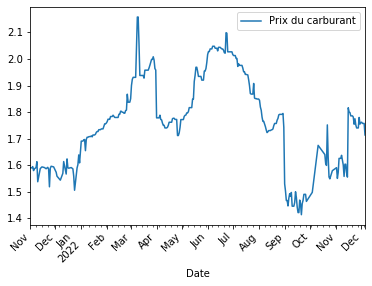

In [27]:
df_carburant.plot(x='Date', y='Prix du carburant')
plt.xticks(rotation=45, ha="right")

## Prétraitement des données

### Nettoyage des données

In [7]:
def baseline_clean(df_list, node_dict):
    '''
    Inputs : liste des DataFrames à concaténer + dictionnaire des nœuds amont/aval pour chaque arc.
    Output : DataFrame complet et nettoyé (filtrage sur les nœuds, interpolation des valeurs manquantes,
    conversion du datetime à la zone horaire de Paris, one-hot encoding des attributs catégoriels,
    élimination des attributs inutiles).
    '''
    
    # On concatène les DataFrames
    df = pd.concat(df_list, ignore_index=True)

    # On filtre les lignes sur les critères de nœuds amont/aval
    criteria_dict = []

    for key, value in node_dict.items():
        criterion = (df["Libelle"]==key) & (df["Libelle noeud amont"]==value[0]) & \
                    (df["Libelle noeud aval"]==value[1])
        criteria_dict.append(criterion)

    criteria = functools.reduce(lambda x,y: x|y, criteria_dict)
    df = df[criteria] 

    # Interpolation des valeurs manquantes
    df["Débit horaire"] = df["Débit horaire"].interpolate()
    df["Taux d'occupation"] = df["Taux d'occupation"].interpolate()

    # On convertit le datetime à la zone horaire locale (Paris)
    df['Date et heure de comptage'] = pd.to_datetime(df['Date et heure de comptage'], utc=True) \
                                            .dt.tz_convert('Europe/Paris') \
                                            .dt.tz_localize(None)

    # One-hot encoding des attributs catégoriels
    trafic = pd.get_dummies(df["Etat trafic"], prefix="Etat trafic")
    arc = pd.get_dummies(df["Etat arc"], prefix="Etat arc")

    df = pd.concat([df, trafic, arc], axis=1)

    # Élimination des attributs inutiles
    df = df.drop(columns=[
      "Identifiant arc",
      "Identifiant noeud amont",
      "Identifiant noeud aval",
      "Date debut dispo data",
      "Date fin dispo data",
      "geo_point_2d",
      "geo_shape",
      "Libelle noeud amont",
      "Libelle noeud aval",
      "Etat trafic", 
      "Etat arc"
      ])

    df.reset_index(drop=True, inplace=True)

    return df

In [8]:
df_list = [champs_elysees, convention, sts_peres]

node_dict = {
    'AV_Champs_Elysees': ('Av_Champs_Elysees-Washington', 'Av_Champs_Elysees-Berri'),
    'Convention': ('Lecourbe-Convention', 'Convention-Blomet'),
    'Sts_Peres': ('Sts_Peres-Voltaire', 'Sts_Peres-Universite')
}

data_clean = baseline_clean(df_list, node_dict)

In [10]:
data_clean.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,0,1,0,0,0,0,1
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,0,1,0,0,0,0,1
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,0,0,0,0,1,0,1
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,0,0,0,0,1,0,1
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,0,1,0,0,0,0,1


### Ajout des données externes : _feature engineering_

#### Vacances et jours féries

In [65]:
# Jours de la semaine

data_clean['Date'] = pd.to_datetime(data_clean["Date et heure de comptage"]).dt.date
data_clean['Jour de la semaine'] = pd.to_datetime(data_clean["Date et heure de comptage"]).dt.dayofweek
data_clean['Jour férié'] = data_clean['Date'].isin(feries)
data_clean['Jour férié'] = data_clean['Jour férié'].replace(True, 1).replace(False, 0)

# One-hot encoding des jours de la semaine

data_clean = pd.concat([
    data_clean,
    pd.get_dummies(data_clean['Jour de la semaine'],
                   prefix='Jour de la semaine',
                   drop_first=False)
], axis=1).drop(columns=['Jour de la semaine'])

data_clean.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide,Date,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,Jour de la semaine_3,Jour de la semaine_4,Jour de la semaine_5,Jour de la semaine_6
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,0,0,0,0,1,0,1,2022-01-01,0.0,0,0,0,0,0,1,0
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,0,0,0,0,1,0,1,2022-01-01,0.0,0,0,0,0,0,1,0
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0


#### Données météorologiques

In [74]:
data_clean = data_clean.merge(df_meteo, left_on='Date et heure de comptage', right_on='datetime', how='left').drop(columns=['datetime'])

data_clean.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide,Date,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,Jour de la semaine_3,Jour de la semaine_4,Jour de la semaine_5,Jour de la semaine_6,maxtempC,mintempC,avgtempC,totalSnow_cm,uvIndex,tempC,windspeedKmph,winddirDegree,weatherCode,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,15,9,12,0.0,4,12,11,173,113,0.0,79,10,1025,4,12,8,11,16,11,True
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,15,9,12,0.0,3,9,8,175,113,0.0,93,10,1025,9,9,8,8,16,8,False
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,0,0,0,0,1,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,15,9,12,0.0,1,11,8,191,113,0.0,72,10,1023,19,11,7,11,16,11,False
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,0,0,0,0,1,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,15,9,12,0.0,1,12,8,190,113,0.0,72,10,1023,21,12,7,11,15,11,False
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,15,9,12,0.0,3,9,9,168,113,0.0,91,10,1025,7,9,8,8,18,8,True


#### Paris sans voiture

In [80]:
data_clean = data_clean.merge(paris_respire, left_on='Date et heure de comptage', right_on='date', how='left').drop(columns=['date'])
data_clean['paris_respire'] = data_clean['paris_respire'].replace(np.nan, False)

data_clean.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide,Date,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,Jour de la semaine_3,Jour de la semaine_4,Jour de la semaine_5,Jour de la semaine_6,paris_respire
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,0,0,0,0,1,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,0,0,0,0,1,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False


#### Travaux perturbateurs

In [87]:
data_clean.loc[(data_clean['Date et heure de comptage'] > "2022-07-04") &
        (data_clean['Date et heure de comptage'] < "2023-05-12") &
        (data_clean['Libelle']=='Convention'), 'perturbation_travaux'] = 2

data_clean.loc[(data_clean['Date et heure de comptage'] > "2022-06-13") & 
        (data_clean['Date et heure de comptage'] < "2023-12-01") &
        (data_clean['Libelle']=='AV_Champs_Elysees'), 'perturbation_travaux'] = 1

data_clean.loc[(data_clean['Date et heure de comptage'] > "2021-07-12") & 
        (data_clean['Date et heure de comptage'] < "2022-12-31") &
        (data_clean['Libelle']=='Sts_Peres'), 'perturbation_travaux'] = 1

data_clean['perturbation_travaux'] = data_clean['perturbation_travaux'].fillna(0)

data_clean.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide,Date,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,Jour de la semaine_3,Jour de la semaine_4,Jour de la semaine_5,Jour de la semaine_6,paris_respire,perturbation_travaux
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False,0.0
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False,0.0
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,0,0,0,0,1,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False,0.0
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,0,0,0,0,1,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False,0.0
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,0,1,0,0,0,0,1,2022-01-01,0.0,0,0,0,0,0,1,0,False,0.0


#### Prix du carburant en région parisienne

In [90]:
data_clean['Date'] = data_clean['Date et heure de comptage'].astype(str).apply(lambda row: row[:10])
data_clean['Date'] = pd.to_datetime(data_clean['Date'])

data_final = data_clean.merge(df_carburant, on='Date', how='left')
data_final = data_final.drop('Date', axis=1)

data_final.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,Jour de la semaine_3,Jour de la semaine_4,Jour de la semaine_5,Jour de la semaine_6,paris_respire,perturbation_travaux,Prix du carburant
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,0,1,0,0,0,0,1,0.0,0,0,0,0,0,1,0,False,0.0,1.691
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,0,1,0,0,0,0,1,0.0,0,0,0,0,0,1,0,False,0.0,1.691
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,0,0,0,0,1,0,1,0.0,0,0,0,0,0,1,0,False,0.0,1.691
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,0,0,0,0,1,0,1,0.0,0,0,0,0,0,1,0,False,0.0,1.691
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,0,1,0,0,0,0,1,0.0,0,0,0,0,0,1,0,False,0.0,1.691


## Modèles de prédiction

### Exploration de modèles de prédiction

Il est important de backtester nos modèles sur des données historiques pour juger de leurs performances. Deux méthodes s'offrent à nous : un simple _train-test split_ utilisant la dernière semaine en tant qu'ensemble de test, ou bien une _rolling window_ permettant de _fit_ le modèle successivement sur une fenêtre glissante ne laissant apparaître qu'une portion des données.

Nous avons testé un certain nombre de modèles, et avons comparé leurs performances en mesurant la RMSE de leurs prédictions selon ces deux méthodes.

Les modèles testés (avec le notebook correspondant, à trouver sur la page du GitHub) sont :

- Régression linéaire avec une _backward stepwise feature selection_ **[models/linear_regression.ipynb]**
- Prophet **[models/Prophet.ipynb]**
- SARIMA **[models/sarima.ipynb]**
- Modèle additif **[models/additive.ipynb]**

### Modèle retenu et justification

Le modèle retenu, au vu de ses performances données par la métrique RMSE, est le modèle additif-time series. Ce dernier fonctionne sur la décomposition des données des séries temporelles en 3 composants :

- la tendance (_trend_) : modélise les évolutions à long terme
- la saisonnalité : représente les évolutions périodiques en utilisant des _Fourier features_
- l'aspect cyclique : modélise la dépendance séquentielle en utilisant des _lag embeddings_

Pour plus de détails sur le modèle, veuillez consulter le notebook **[models/additive.ipynb]**.

## Génération des prédictions

La génération des prédictions est effectuée dans le notebook **[models/additive.ipynb]**. Dans ce notebook, on peut trouver 6 parties, groupées par 2 : pour chaque rue, une partie d'exploration et une partie de génération des prédictions, intitulée « [Rue] FINAL ». 

Au terme de chaque partie finale, un fichier CSV est généré, tel que :

- **chmps_preds.csv**
- **sts_preds.csv**
- **convention.csv**

Vous pourrez trouver ces fichiers de résultats dans le dossier **predictions** de notre GitHub.

### Test du format de l'output

In [ ]:
df_elysee=pd.read_csv("chmps_preds.csv", sep=";", parse_dates=["Unnamed: 0"])
df_elysee.rename(columns={"Unnamed: 0":"datetime","Taux d'occupation":"taux_occupation", "Débit horaire":"debit_horaire"},inplace=True)
df_elysee['datetime']=df_elysee['datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
df_elysee['arc']="Champs-Elysées"

df_sts=pd.read_csv("sts_preds.csv", sep=";", parse_dates=["Unnamed: 0"])
df_sts.rename(columns={"Unnamed: 0":"datetime","Taux d'occupation":"taux_occupation","Débit horaire":"debit_horaire"},inplace=True)
df_sts['datetime']=df_sts['datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
df_sts['arc']="Saint-Pères"

df_Convention=pd.read_csv("convention_preds.csv", sep=";", parse_dates=["Unnamed: 0"])
df_Convention.rename(columns={"Unnamed: 0":"datetime","Taux d'occupation":"taux_occupation","Débit horaire":"debit_horaire"},inplace=True)
df_Convention['datetime']=df_Convention['datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
df_Convention['arc']="Convention"

out = pd.concat([df_elysee,df_sts, df_Convention], ignore_index=True)

In [ ]:
def test_format_and_export_output(output_df, output_directory, name_of_the_group): 
    
    output_columns = {"arc": object, "datetime": object, "debit_horaire": float,"taux_occupation": float}

    # 1. Check relevant columns are in output dataframe 
    assert sorted(list(output_df.columns)) == list(output_columns.keys()), "Some columns are missing or unnecessary columns are in output" # 2. Check types

    for col, col_type in output_columns.items():
        assert output_df[col].dtype == col_type, f"Column {col} does not have type {col_type}"

    # 3. Check datetime string has right format
    try:
        output_df.datetime.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M"))
    except ValueError as e: 
        raise e

    # 4. Check `arc` columns has right values
    assert sorted(list(output_df["arc"].unique())) == [ "Champs-Elysées","Convention","Saint-Pères",], "Output does not have expected unique values for column `arc`"

    # 5. Check dataframe has right number of rows
    assert output_df.shape[0] == 360, f"Expected number of rows is 360, output has{output_df.shape[0]}"

    # 6. Export output
    output_path = Path(output_directory) / f"output_{name_of_the_group}.csv" 
    print(f"[SAVE OUTPUT] Saving output here: {output_path}") 
    output_df[output_columns.keys()].to_csv(output_path, sep=";")

In [ ]:
test_format_and_export_output(output, "results", "eCSpress")

## Conclusion

Ce Datathon nous a permis d'appréhender la valeur ajoutée de la Data Science pour l'optimisation d'un cas Business concret. Il nous a également offert l'opportunité de développer nos compétences en Data Science, en particulier en analyse des prédictions de Times Series, ainsi qu'en réalisation de projet.

Nous tenons à remercier BCG GAMMA pour l'organisation de ce Datathon.